In [1]:
from ham import *
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# ==== Model Parameters ====
n_batch = 100
n_image = 28*28
n_classes = 10
device = torch.device('cpu')
dtype = torch.float32

In [3]:
# ==== Create Model ====
neurons = {
    'input': TanhNeuron(shape=(n_image,)),
    'hidden': ReluNeuron(shape=(n_image,)),
    'label': SoftmaxNeuron(shape=(n_classes,)),
}

synapses = {
    's0': DenseSynapse(n_image, n_image, device=device, dtype=dtype),
    's1': DenseSynapse(n_image, n_classes, device=device, dtype=dtype)
}

connections = {
    's0': ['input', 'hidden'],
    's1': ['hidden', 'label'],
}

model = HAM(neurons, synapses, connections)

In [4]:
# ==== Load Data ====
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0), (1.0))])
train_set = datasets.MNIST(os.path.expanduser('~/data'), train=True, download=True, transform=transform)
test_set = datasets.MNIST(os.path.expanduser('~/data'), train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n_batch)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=n_batch)

In [5]:
# ==== Setup Optimizer ====
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# ==== Training Loop ====
n_epochs = 1
depth = 5
dt = 0.1

In [7]:
for e in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        
        # Init states
        states = model.init_states(n_batch=n_batch, device=device, dtype=dtype, requires_grad=True)
        states['input'] = x.view(n_batch, -1).to(device=device, dtype=dtype).requires_grad_(True)

        # Move labels to device
        y = y.to(device=device, dtype=torch.long)

        optim.zero_grad()

        for d in range(depth):
            activations = model.neuron_activations(states)
            updates = model.updates(states, activations)
            states = model.step(states, updates, dt, pin={'input'})
        
        logits = states['label']
        loss = F.cross_entropy(logits, y)
        print(f'batch = {i}, loss = {loss.item():2.8f}', end='\r',  flush=True)
        loss.backward()
        optim.step()

Text(0.5, 1.0, '4')

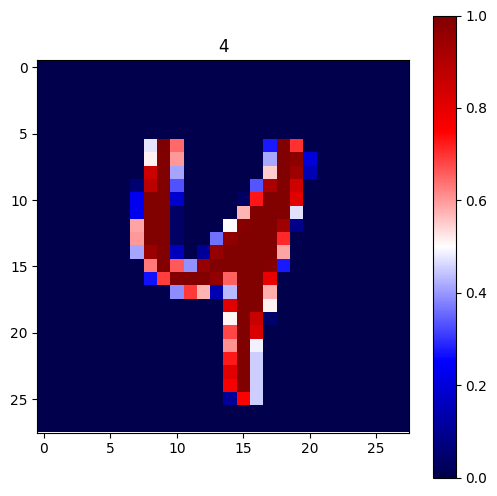

In [13]:
# Plot results
idx = 42
x, y = test_set[idx]
x = x.view(1, -1).to(device=device, dtype=dtype)
y = torch.tensor(y).view(1, -1).to(device=device, dtype=torch.long)

plt.figure(figsize=(6, 6))
plt.imshow(x.detach().squeeze().reshape(28, 28).numpy(), cmap='seismic')
plt.colorbar()
plt.title(f'{y.item()}')

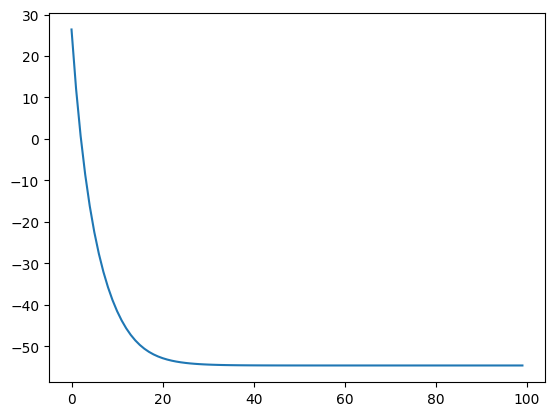

In [14]:
states = model.init_states(n_batch=1, device=device, dtype=dtype, requires_grad=True)
states['input'] = x.requires_grad_(True)

dt = 0.01
nt = 100
energies = []
for t in range(nt):
    activations = model.neuron_activations(states)
    updates, energy = model.updates(states, activations, return_energy=True)
    energies.append(energy.item())
    states = model.step(states, updates, dt, pin={'input'})
    
plt.plot(energies)

In [15]:
activations = model.neuron_activations(states)
probs = activations['label']
y_pred = torch.argmax(probs.flatten())
print(f'y_true = {y.item()}, y_pred = {y_pred.item()}')

y_true = 4, y_pred = 4


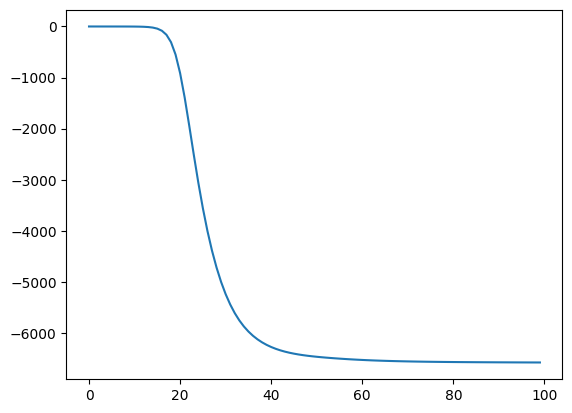

In [16]:
states = model.init_states(n_batch=1, device=device, dtype=dtype, requires_grad=True)
states['label'] = F.one_hot(torch.tensor(0), num_classes=10).view(1, -1).to(device=device, dtype=dtype).requires_grad_(True)

dt = 0.01
nt = 100
energies = []
for t in range(nt):
    activations = model.neuron_activations(states)
    updates, energy = model.updates(states, activations, return_energy=True)
    energies.append(energy.item())
    states = model.step(states, updates, dt)
    
plt.plot(energies)

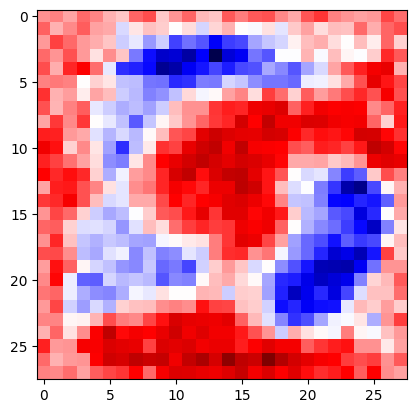

In [17]:
plt.imshow(states['input'].detach().reshape(28, 28).numpy(), cmap='seismic')